<a href="https://colab.research.google.com/github/jumbokh/csu1112-class/blob/main/class/vision/pytorch_image_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

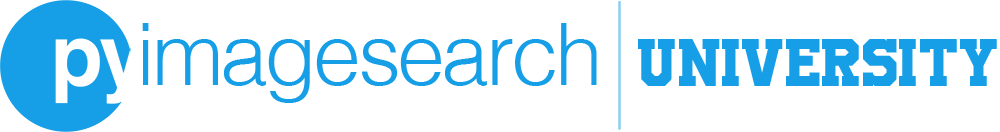

# Image Data Loaders in PyTorch
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Image Data Loaders in PyTorch](https://www.pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/) blog post published on 2021-10-04.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-image-dataloader/pytorch-image-dataloader.zip
!unzip -qq pytorch-image-dataloader.zip
%cd pytorch-image-dataloader

--2023-05-13 03:14:50--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/pytorch-image-dataloader/pytorch-image-dataloader.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.248.170, 52.218.242.217, 52.92.133.90, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.248.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 957931 (935K) [application/zip]
Saving to: ‘pytorch-image-dataloader.zip’

pytorch-image-datal 100%[===================>] 935.48K  1.10MB/s    in 0.8s    

2023-05-13 03:14:52 (1.10 MB/s) - ‘pytorch-image-dataloader.zip’ saved [957931/957931]

/content/pytorch-image-dataloader


### Download the dataset

In [2]:
! wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
! tar xf flower_photos.tgz

--2023-05-13 03:14:52--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  24.2MB/s    in 9.7s    

2023-05-13 03:15:02 (22.4 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



## Blog Post Code

### Import Packages

In [3]:
# import the necessary packages
from torchvision.datasets import ImageFolder, MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import shutil
import os

### Splitting Dataset into Training and Validation set

In [4]:
class config:
    # specify path to the flowers and mnist dataset
    FLOWERS_DATASET_PATH = "flower_photos"
    MNIST_DATASET_PATH = "mnist"

    # specify the paths to our training and validation set 
    TRAIN = "train"
    VAL = "val"

    # set the input height and width
    INPUT_HEIGHT = 128
    INPUT_WIDTH = 128

    # set the batch size and validation data split
    BATCH_SIZE = 8
    VAL_SPLIT = 0.1

In [5]:
def copy_images(imagePaths, folder):
	# check if the destination folder exists and if not create it
	if not os.path.exists(folder):
		os.makedirs(folder)

	# loop over the image paths
	for path in imagePaths:
		# grab image name and its label from the path and create
		# a placeholder corresponding to the separate label folder
		imageName = path.split(os.path.sep)[-1]
		label = path.split(os.path.sep)[-2]
		labelFolder = os.path.join(folder, label)

		# check to see if the label folder exists and if not create it
		if not os.path.exists(labelFolder):
			os.makedirs(labelFolder)

		# construct the destination image path and copy the current
		# image to it
		destination = os.path.join(labelFolder, imageName)
		shutil.copy(path, destination)

In [6]:
# load all the image paths and randomly shuffle them
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(config.FLOWERS_DATASET_PATH))
np.random.shuffle(imagePaths)

# generate training and validation paths
valPathsLen = int(len(imagePaths) * config.VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen
trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]

# copy the training and validation images to their respective
# directories
print("[INFO] copying training and validation images...")
copy_images(trainPaths, config.TRAIN)
copy_images(valPaths, config.VAL)

[INFO] loading image paths...
[INFO] copying training and validation images...


### PyTorch Dataset and DataLoaders

In [7]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(config.INPUT_HEIGHT,
	config.INPUT_WIDTH))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

# initialize our training and validation set data augmentation
# pipeline
trainTransforms = transforms.Compose([resize, hFlip, vFlip, rotate,
	transforms.ToTensor()])
valTransforms = transforms.Compose([resize, transforms.ToTensor()])

In [8]:
# initialzie the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root=config.TRAIN,
	transform=trainTransforms)
valDataset = ImageFolder(root=config.VAL, 
	transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(
	len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(
	len(valDataset)))

[INFO] loading the training and validation dataset...
[INFO] training dataset contains 3303 samples...
[INFO] validation dataset contains 367 samples...


In [9]:
# create training and validation set dataloaders
print("[INFO] creating training and validation set dataloaders...")
trainDataLoader = DataLoader(trainDataset, 
	batch_size=config.BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=config.BATCH_SIZE)

[INFO] creating training and validation set dataloaders...


In [10]:
# grab a batch from both training and validation dataloader
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))

In [11]:
def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(config.BATCH_SIZE, config.BATCH_SIZE))

	# loop over the batch size
	for i in range(0, config.BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)

		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")

		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]

		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")

	# show the plot
	plt.tight_layout()
	plt.show()

[INFO] visualizing training batch...


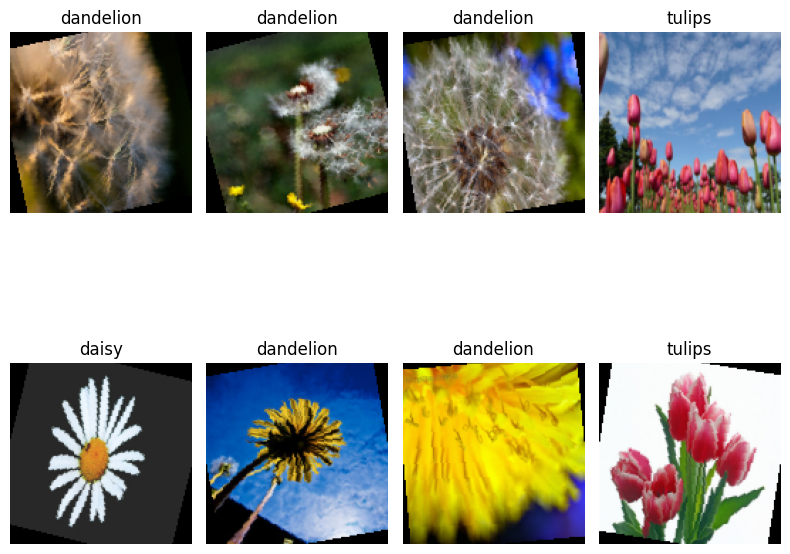

In [12]:
# visualize the training set batch
print("[INFO] visualizing training batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")

[INFO] visualizing validation batch...


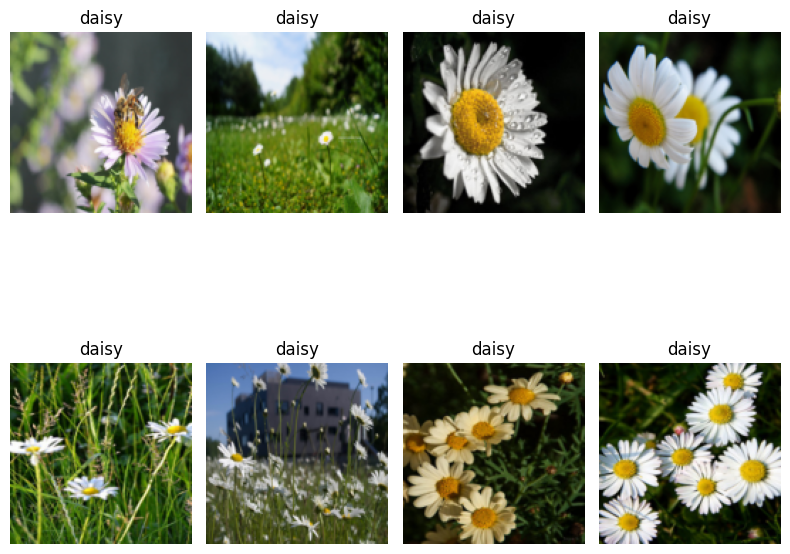

In [13]:
# visualize the validation set batch
print("[INFO] visualizing validation batch...")
visualize_batch(valBatch, valDataset.classes, "val")

### Built-in Datasets

In [14]:
# define the transform
transform = transforms.Compose([transforms.ToTensor()])

# initialize the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = MNIST(root=config.MNIST_DATASET_PATH, train=True,
	download=True, transform=transform)
valDataset = MNIST(root=config.MNIST_DATASET_PATH, train=False,
	download=True, transform=transform)

[INFO] loading the training and validation dataset...


100%|██████████| 9912422/9912422 [00:00<00:00, 435324969.84it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 120773373.70it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 98563304.64it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4408824.06it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [15]:
# create training and validation set dataloaders
print("[INFO] creating training and validation set dataloaders...")
trainDataLoader = DataLoader(trainDataset, 
	batch_size=config.BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=config.BATCH_SIZE)

[INFO] creating training and validation set dataloaders...


In [16]:
# grab a batch from both training and validation dataloader
trainBatch = next(iter(trainDataLoader))
valBatch = next(iter(valDataLoader))

In [17]:
def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
	figsize=(config.BATCH_SIZE, config.BATCH_SIZE))

	# loop over the batch size
	for i in range(0, config.BATCH_SIZE):
		# create a subplot
		ax = plt.subplot(2, 4, i + 1)

		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")

		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]

		# show the image along with the label
		plt.imshow(image[..., 0], cmap="gray")
		plt.title(label)
		plt.axis("off")

	# show the plot
	plt.tight_layout()
	plt.show()

[INFO] visualizing training batch...


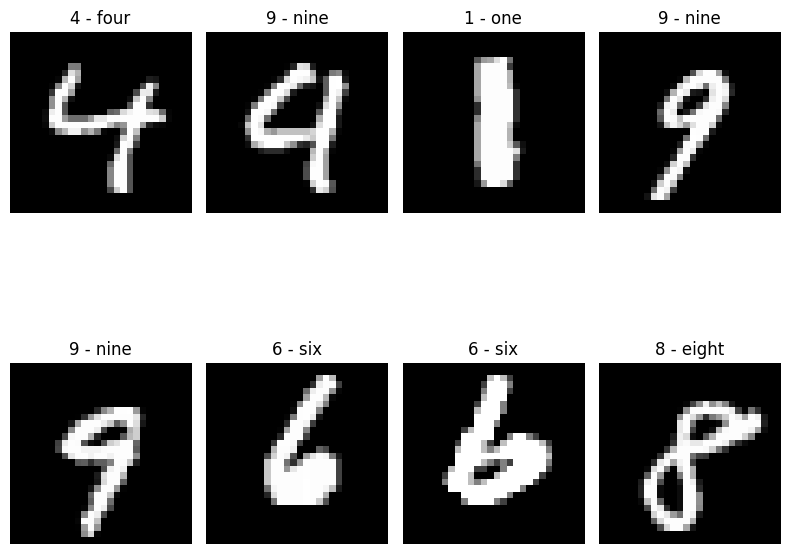

In [18]:
# visualize the training set batch
print("[INFO] visualizing training batch...")
visualize_batch(trainBatch, trainDataset.classes, "train")

[INFO] visualizing validation batch...


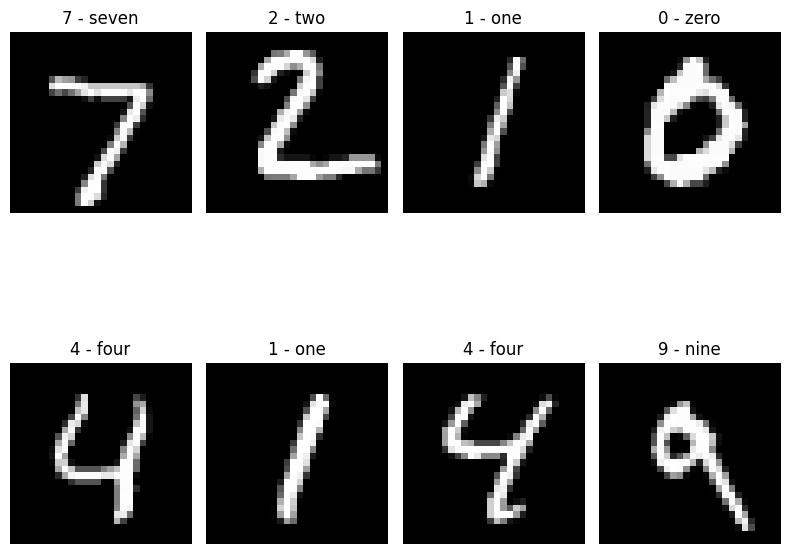

In [19]:
# visualize the validation set batch
print("[INFO] visualizing validation batch...")
visualize_batch(valBatch, valDataset.classes, "val")

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Image Data Loaders in PyTorch*](https://www.pyimagesearch.com/2021/10/04/image-data-loaders-in-pytorch/) published on 2021-10-04.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```